# Filter Hand Poses

## Setup

This was run locally

In [183]:
%%capture
!pip install h5py
!pip install filterpy
!pip install pykalman

In [184]:
import h5py
import numpy as np
import filterpy
import filterpy
from matplotlib import pyplot as plt
%matplotlib inline 

### Load File
You will need to change the filename:

In [185]:
file_name='/home/mjsobrep/Downloads/data/028/target-touch/full_data-novid.hdf5'
cam='upper'
hand='right'

In [186]:
data = h5py.File(file_name, 'r')

## Explore Data

We need to do some data filtering. Anything with x and y = 0 is invalid (it was junk data that was saved that way to be obvious). We also want to be able to get time data...

In [187]:
def simple_filter_wrist(data, hand, cam='upper'):
    time = data[f'vid/{cam}/color/time'] - data[f'vid/{cam}/color/time'][0]
    xy=data[f'vid/{cam}/pose/mp-hands/{hand}/keypoints/color'][:,0,0:2]
    conf=data[f'vid/{cam}/pose/mp-hands/{hand}/confidence'][:]
    valid = np.any(xy!=0, axis=1)
    return (time[valid], xy[valid], conf[valid])

### Plot wrists

Going to look at both hands, in the mp-hands tracker, where the wrist is at index 0

In [188]:
def plot_wrist(data,hand,cam='upper', frames=None, time_range=None):
    if frames and time_range:
        raise ValueError('only provide one of frames and time_range')
    
    time, xy, conf = simple_filter_wrist(data, hand)
    start_idx=frames[0] if frames else 0
    end_idx=frames[1] if frames else len(time)
    start_idx = np.searchsorted(time,time_range[0], side='right') if time_range else start_idx
    end_idx = np.searchsorted(time,time_range[1],side='right') if time_range else end_idx
    
    plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(311)
    plt.tight_layout(pad=3)
    plt.plot(time[start_idx:end_idx] ,xy[start_idx:end_idx,0])
    plt.title('x')
    plt.subplot(312)
    plt.plot(time[start_idx:end_idx] ,xy[start_idx:end_idx,1])
    plt.title('y')
    plt.subplot(313)
    plt.plot(time[start_idx:end_idx] ,conf[start_idx:end_idx])
    plt.title('confidence')

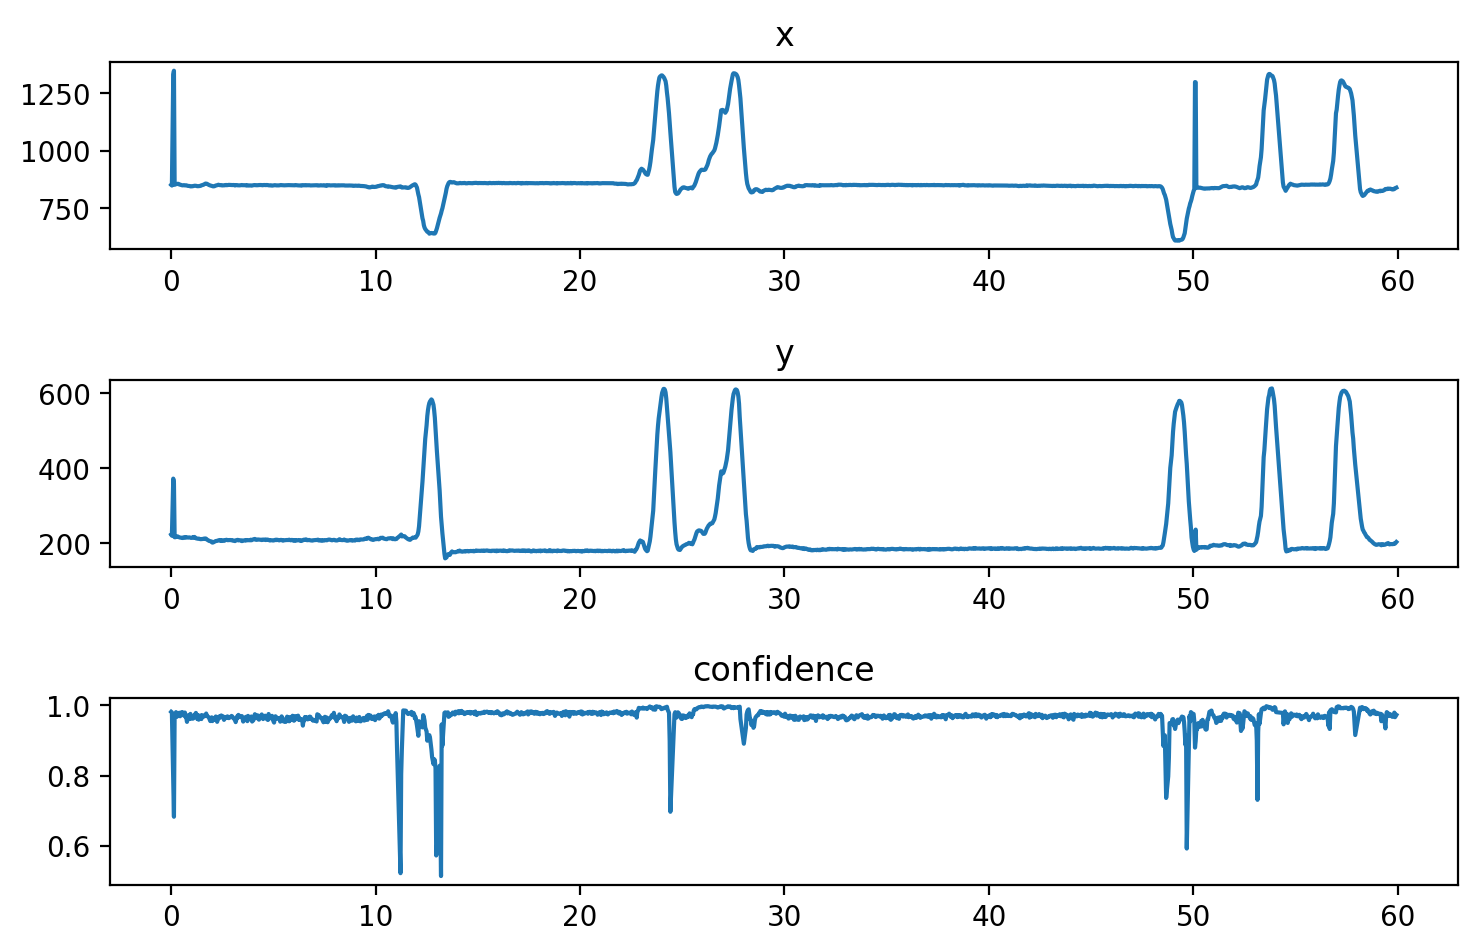

In [189]:
plot_wrist(data, hand)

Every so often confidence drops ver low and we get mess. We can see that when confidence drops towards zero, measurements easily jump by 500-1000 pixels. Let's also visualize a steady state area:

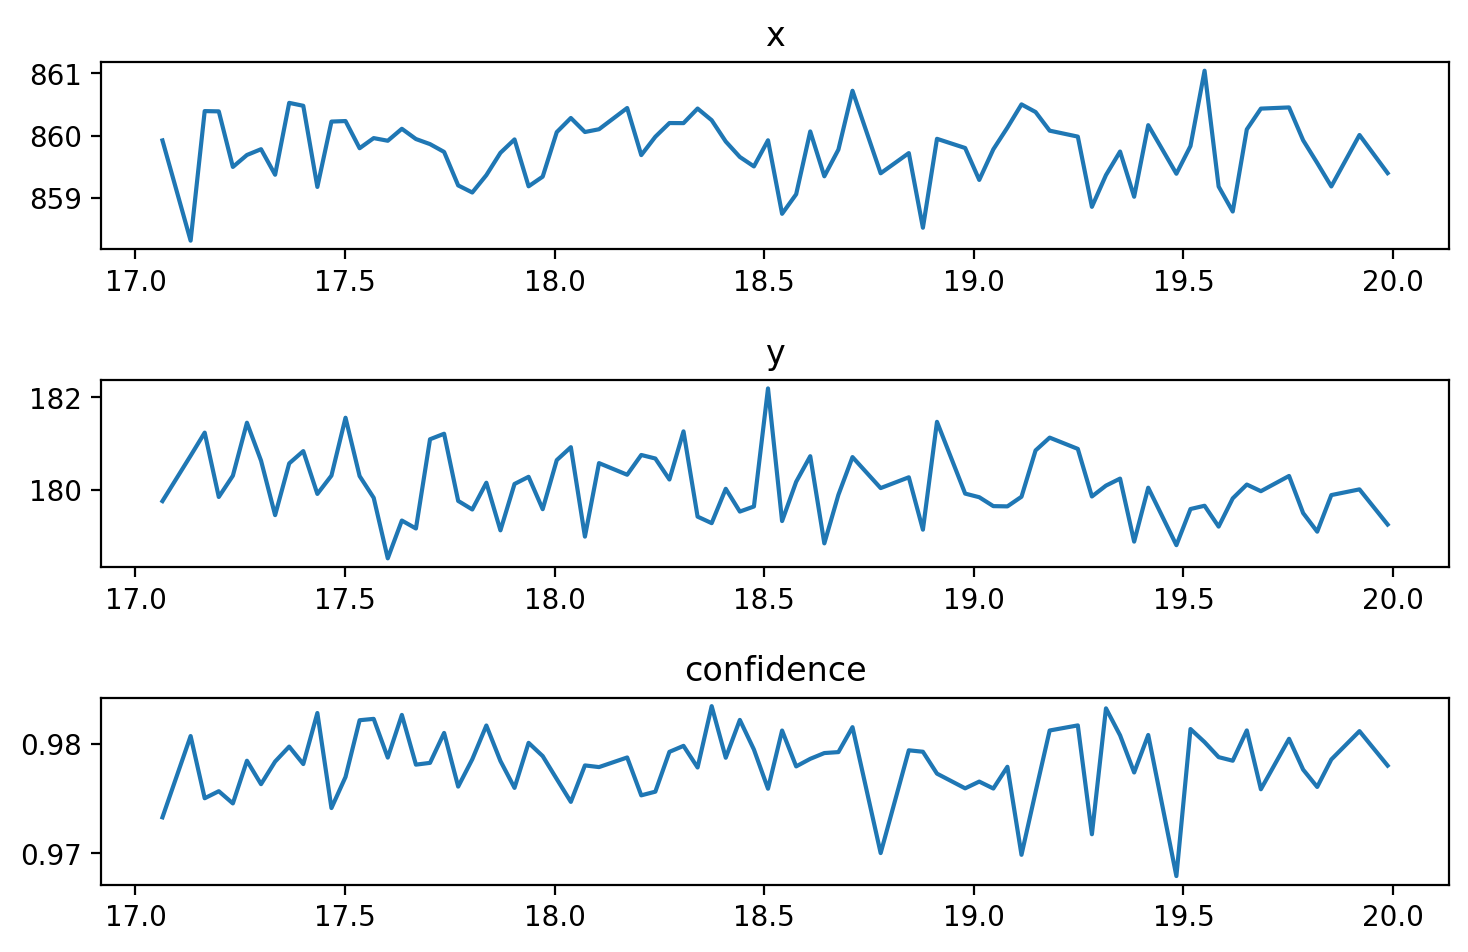

In [190]:
plot_wrist(data, hand ,time_range=(17,20))

In places where no motion is happening, there is still some noise. Smoothing should fix that. This gives us an idea as to the baseline measurement noise.

We need to come up with some way to describe the measurement noise for the kalman filter below. Above, we see that at steady state, there is +/- 2 pixels of noise at confidence = 1. As confidence drops lower, sometimes there is a lot of noise, other times, not so much. I don't think we might just want to use a constant noise for this. 

## Smooth with Kalman Smoother

In [191]:
image_width = 1920
image_height = 1080

# if confidence is less than .1, just skip
times, Zs, confidences = simple_filter_wrist(data, hand)

# Initial vals
x0 = np.array([image_width/2, image_height/2, 0, 0]) # initial assumed state, center of image
P0 = np.array([[(image_width/4)**2, 0 ,0 ,0], # initially could be anywhere in frame
                 [0, (image_height/4)**2, 0, 0],
                 [0, 0 ,500, 0], # no clue what our initial velocity uncertanty is
                 [0, 0, 0, 500]])
# state transistion matrix
Fs = [np.array([[1, 0, dt, 0],
                [0, 1, 0, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) for dt in np.diff(times)]
# Measurement function (we measure x and y positions)
H = np.array([[1,0,0,0],
                 [0,1,0,0]])
# Measurement uncertaintity
# From plots above, we know that high confidence -> +/- 4 and low confidence -> +/- 250
# we are totally removing anything with confidence < .1 So if we do (2/conf)**2, at conf
# ~1, sigma^2 = 4. At conf ~ .1, sigma^2 = 400
Rs = [np.array([[(2/conf)**2, 0],
               [0, (2/conf)**2]]) for conf in confidences]


### Run Kalman filter without esimating noise matricies

In [192]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
                           initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]))

xs, _ = kf.smooth(Zs)

In [193]:
def plot_filter_out(times, Zs, xs):
    plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.tight_layout(pad=3)
    plt.plot(times, Zs[:, 0], label="raw (conf>.1; not x=0&y=0)", dashes=(1,1), color='red')
    plt.plot(times,xs[:, 0], label='smoothed', color='blue', linewidth=.75)
    plt.title('x')
    plt.subplot(212)
    plt.plot(times, Zs[:, 1], label="raw (conf>.1; not x=0&y=0)", dashes=(1,1), color='red')
    plt.plot(times,xs[:, 1], label='smoothed', color='blue', linewidth=.75)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left")
    plt.title('y')


    plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
    start = np.searchsorted(times, 33, side='right') 
    end = np.searchsorted(times, 47, side='right') 
    plt.plot(times[start:end],xs[start:end, 0], label='x-smoothed', color='blue', linewidth=.75)
    plt.plot(times[start:end],xs[start:end, 1], label='y-smoothed', color='blue', linewidth=.75)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left")

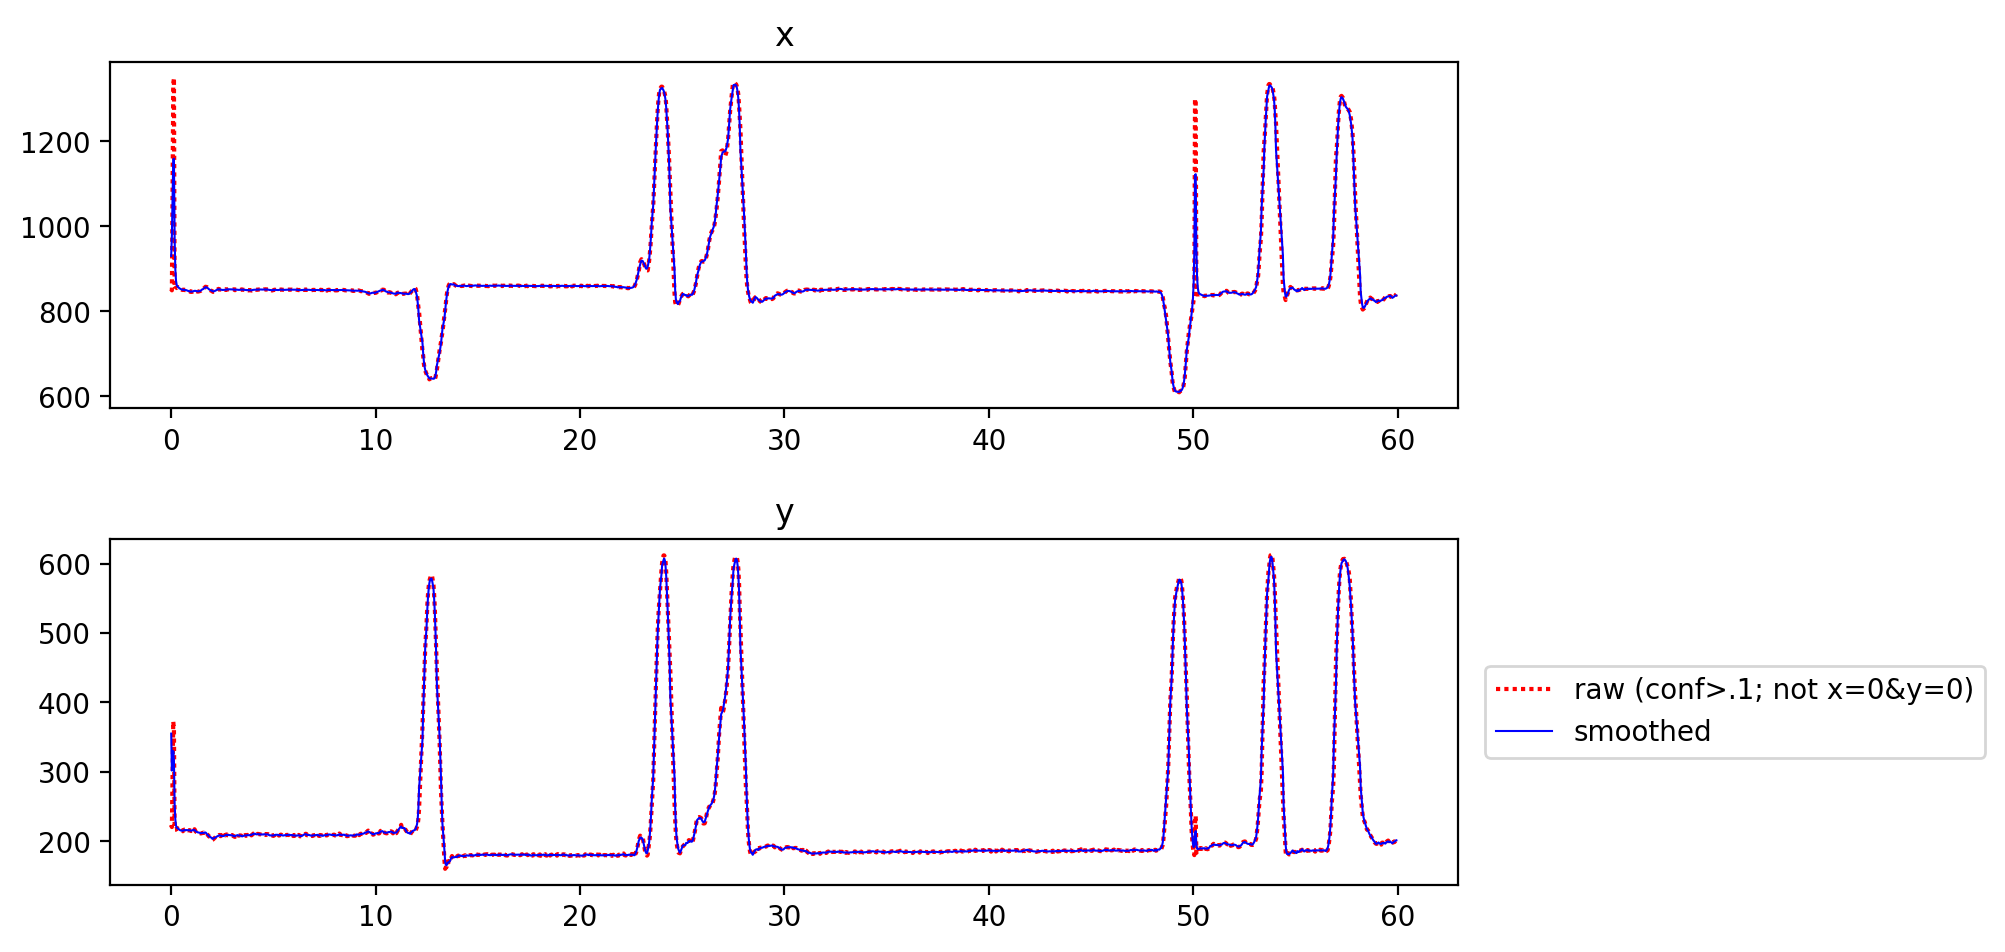

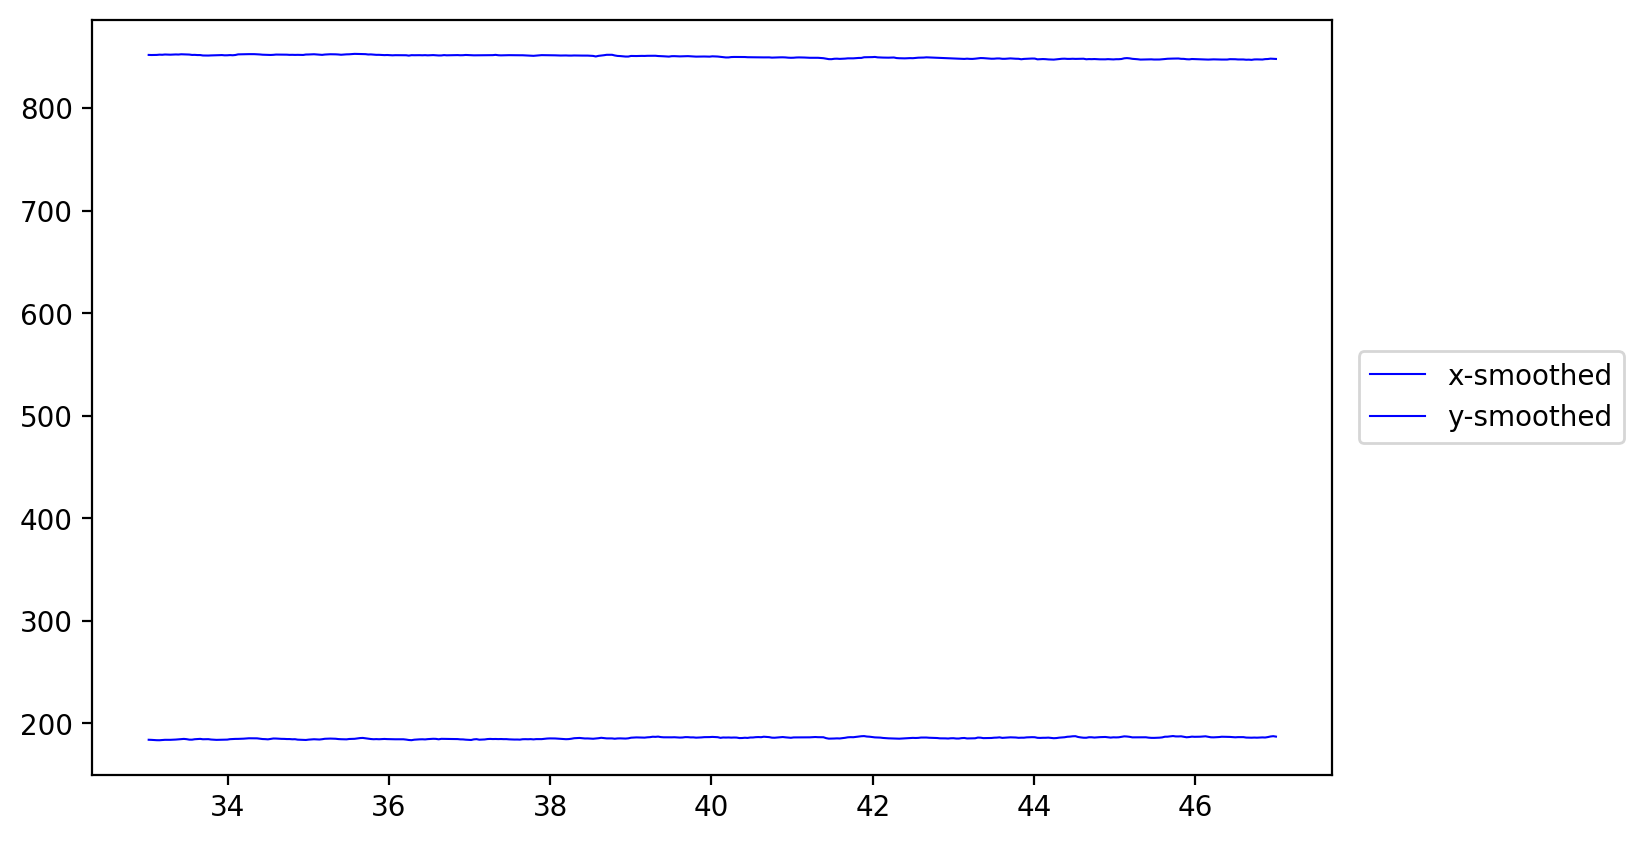

In [194]:
plot_filter_out(times, Zs, xs)

### Attempt to find noise matricies

explore the measurement noise a bit more by looking at a flat area: 

#### Only steady state region

[[ 65.80851794 215.68418552]
 [215.68418551 709.17288328]]
[[3.38288794e+01 1.10494081e+02 1.82235665e-01 1.91710925e+00]
 [1.10494081e+02 3.61120705e+02 5.87111888e-01 6.26716936e+00]
 [1.82232227e-01 5.87106883e-01 2.21342755e-01 2.33260622e-01]
 [1.91709269e+00 6.26713559e+00 2.32979716e-01 9.96379513e-01]]


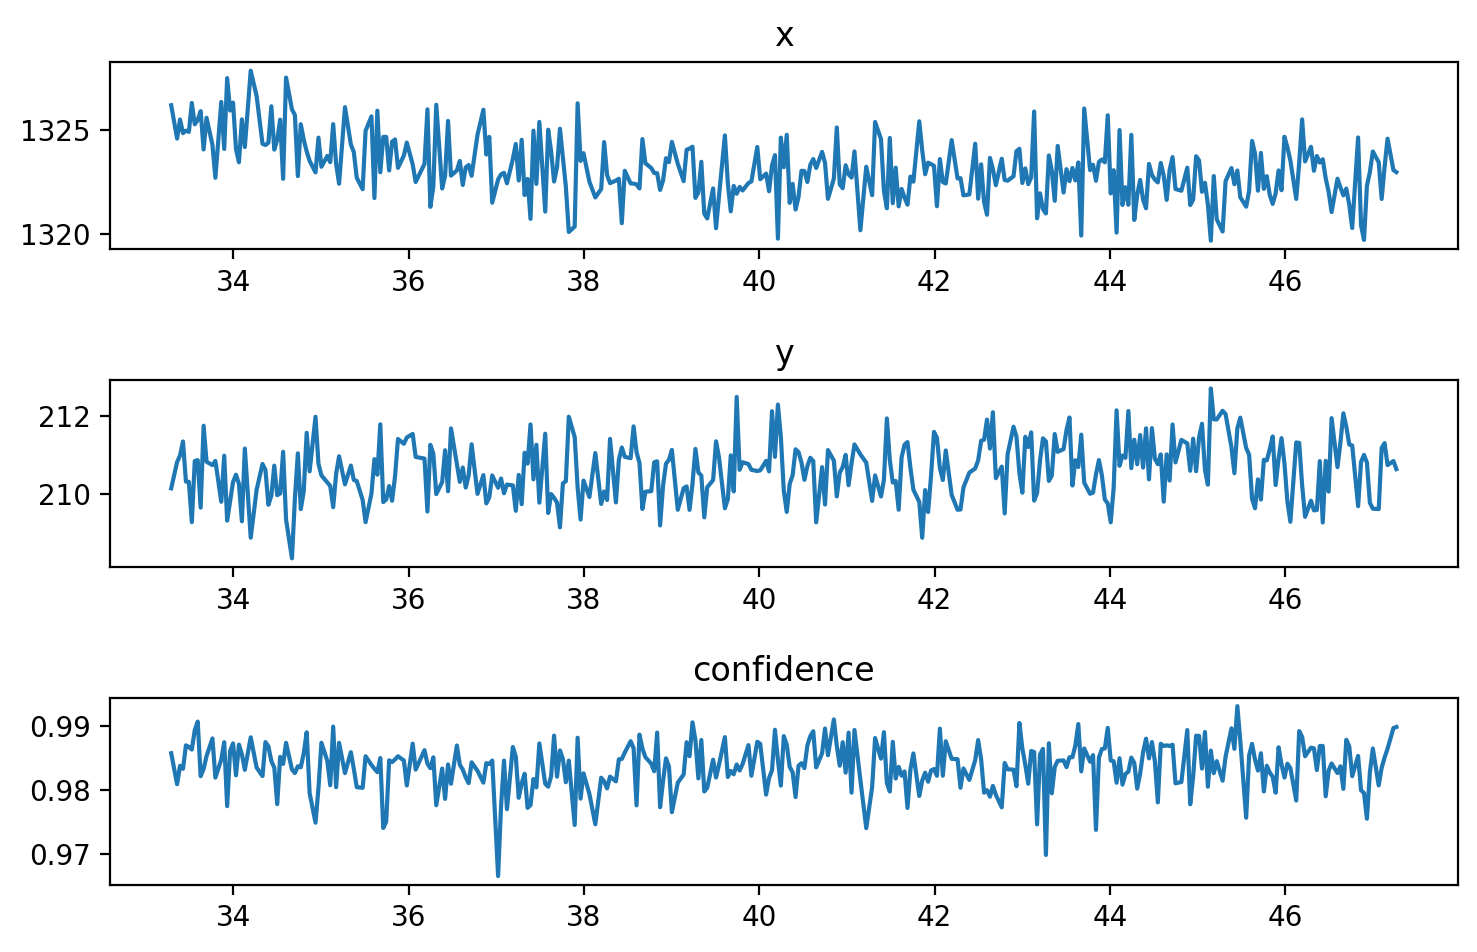

In [195]:
kf_flat = pykalman.KalmanFilter(transition_matrices=Fs[start:end], observation_matrices=H, 
                           initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]))
fitted_flat=kf_flat.em(Zs[start:end], em_vars=('transition_covariance','observation_covariance'), n_iter=50)
start = np.searchsorted(times, 33, side='right') 
end = np.searchsorted(times, 47, side='right') 
plot_wrist(data, 'left' ,frames=(start,end))
print(fitted_flat.observation_covariance)
print(fitted_flat.transition_covariance)

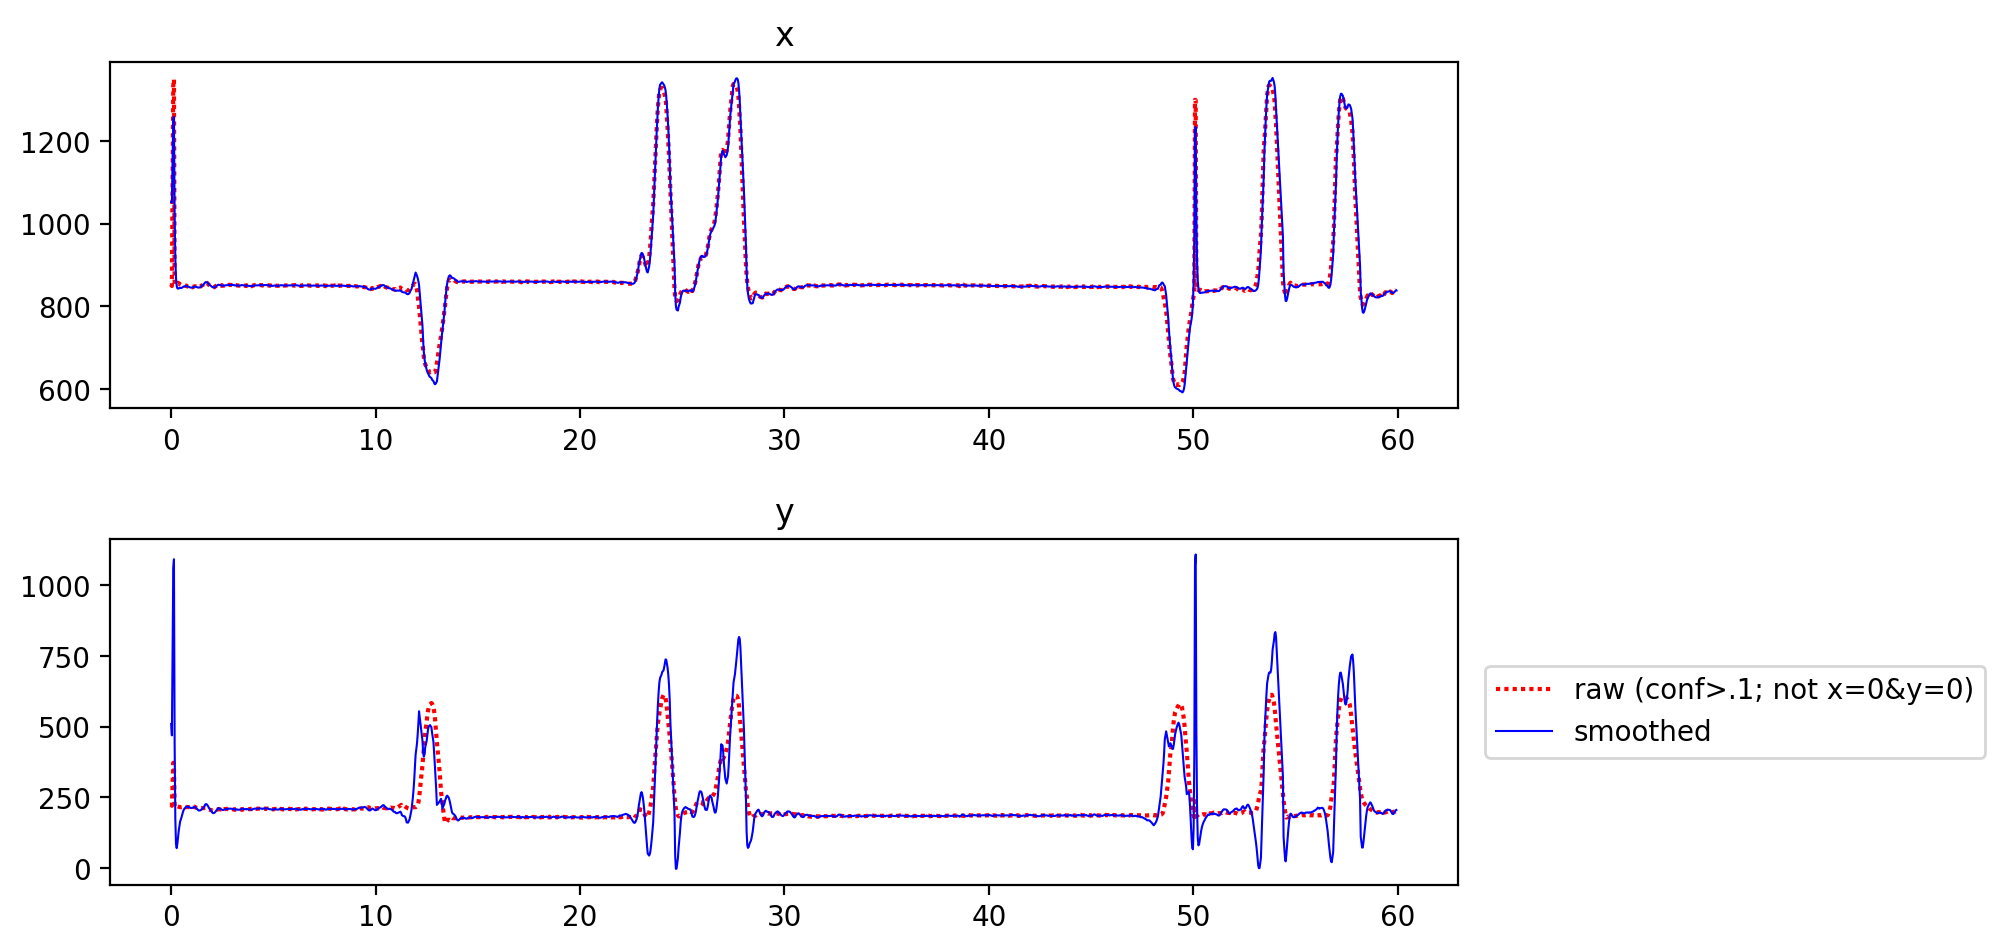

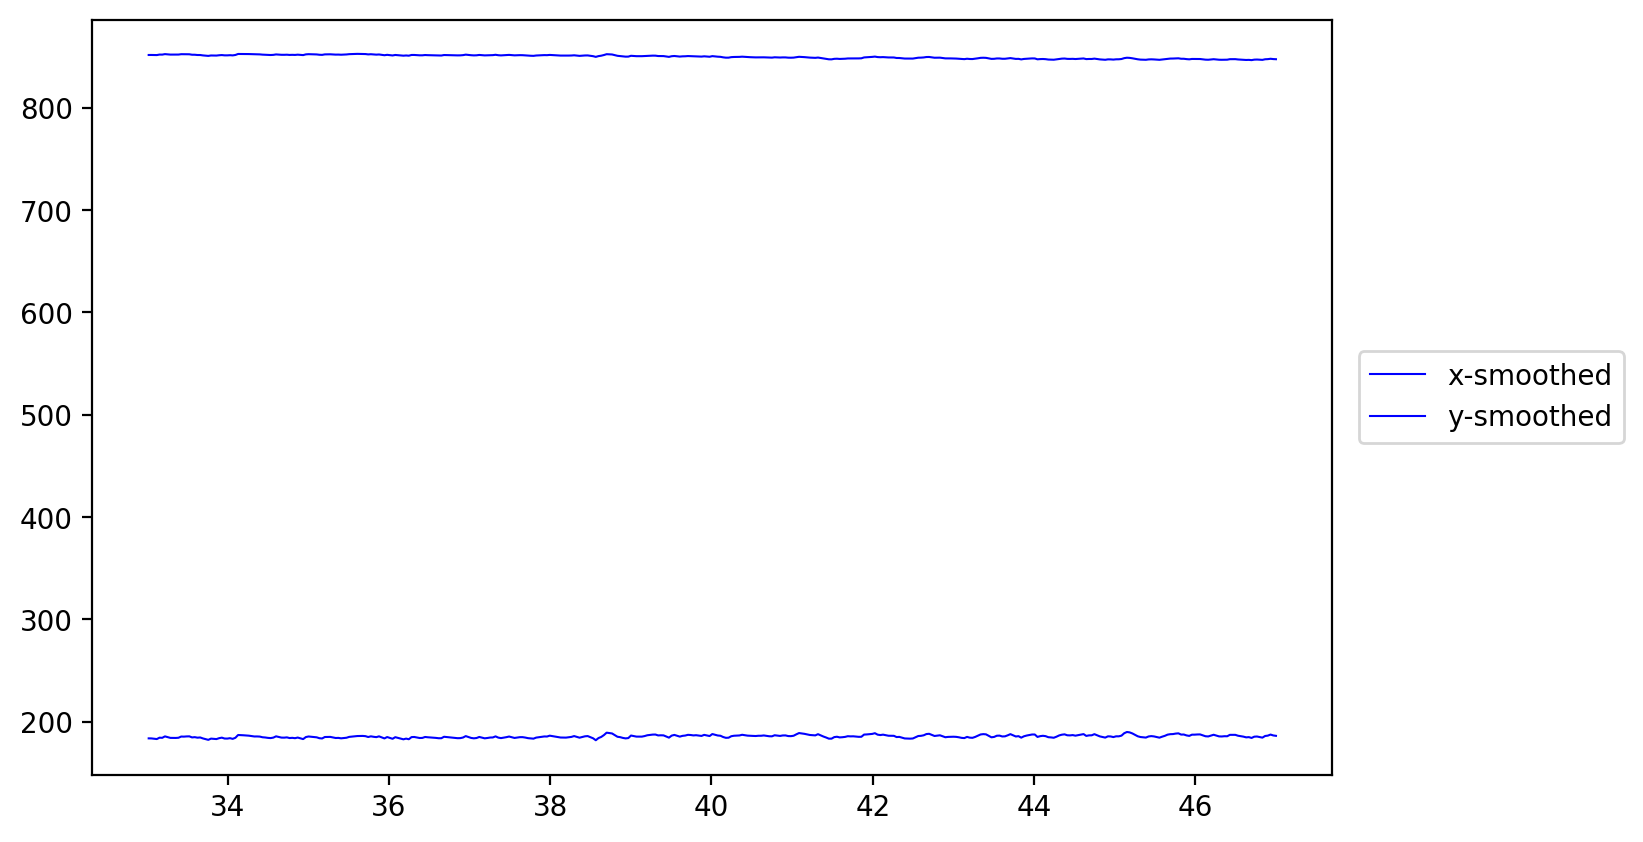

In [196]:
full_fitted_flat = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
                           initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]),
                            observation_covariance=fitted_flat.observation_covariance,
                                        transition_covariance=fitted_flat.transition_covariance)
xs, _ = full_fitted_flat.smooth(Zs)
plot_filter_out(times, Zs, xs)

#### All data

[[ 76.25950119  68.37375728]
 [ 68.3737573  150.98797924]]
[[ 569.77197784   58.34191381   49.03757246   84.76774288]
 [  58.34191879   76.04248387  242.79936686  325.14787532]
 [  49.03757266  242.79925259 6968.05382243 6457.18989697]
 [  84.76785634  325.14787512 6457.19562716 7271.93024701]]


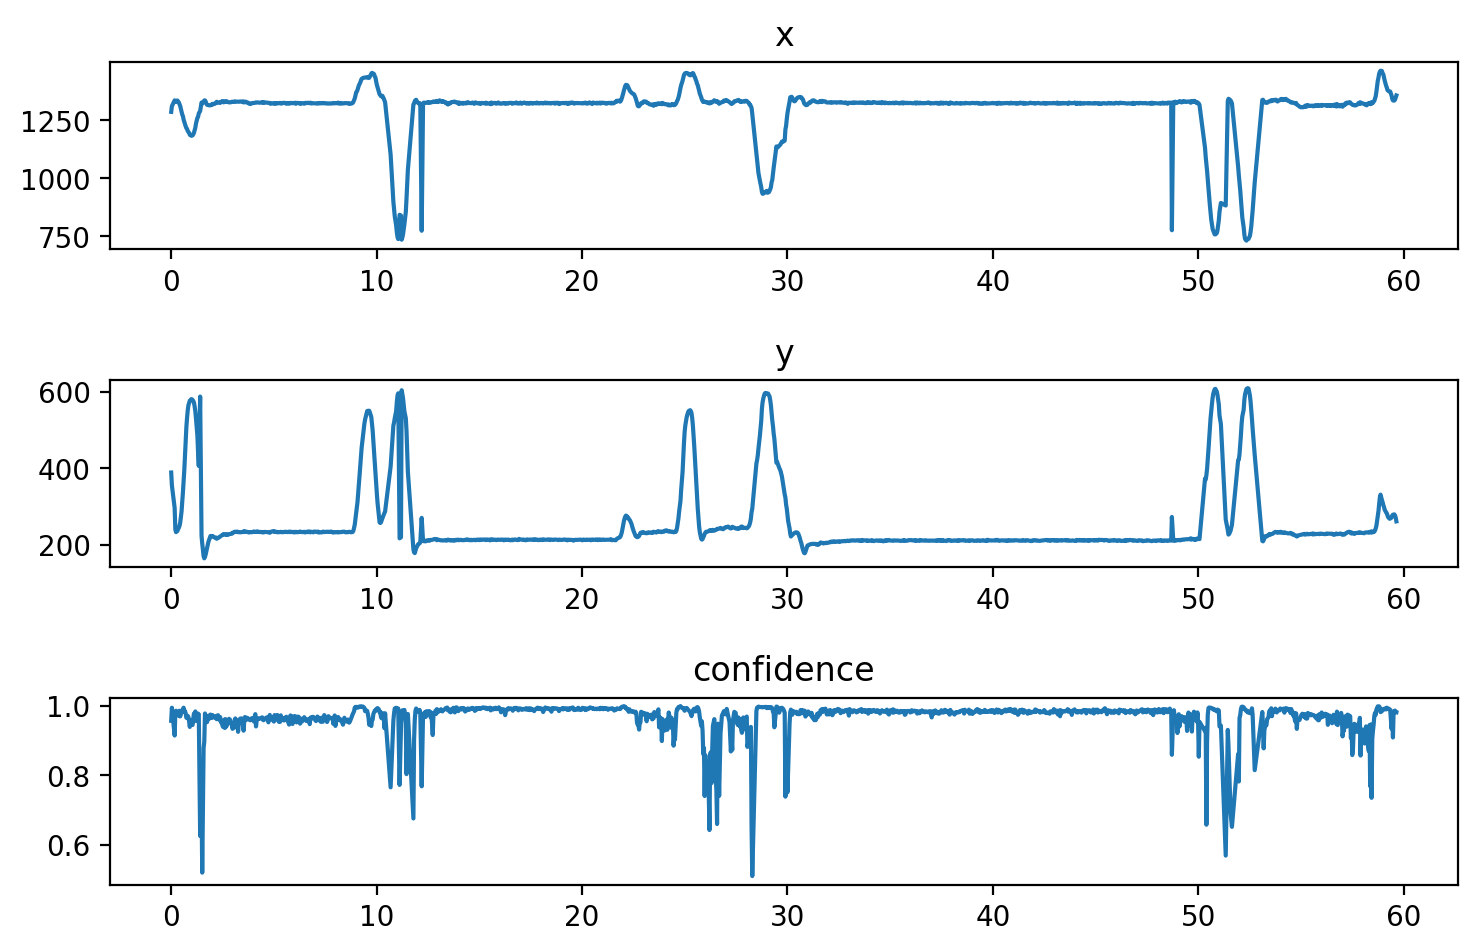

In [197]:
kf_all = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
                           initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]))
fitted_all=kf_all.em(Zs, em_vars=('transition_covariance','observation_covariance'), n_iter=50)
plot_wrist(data, 'left')
print(fitted_all.observation_covariance)
print(fitted_all.transition_covariance)

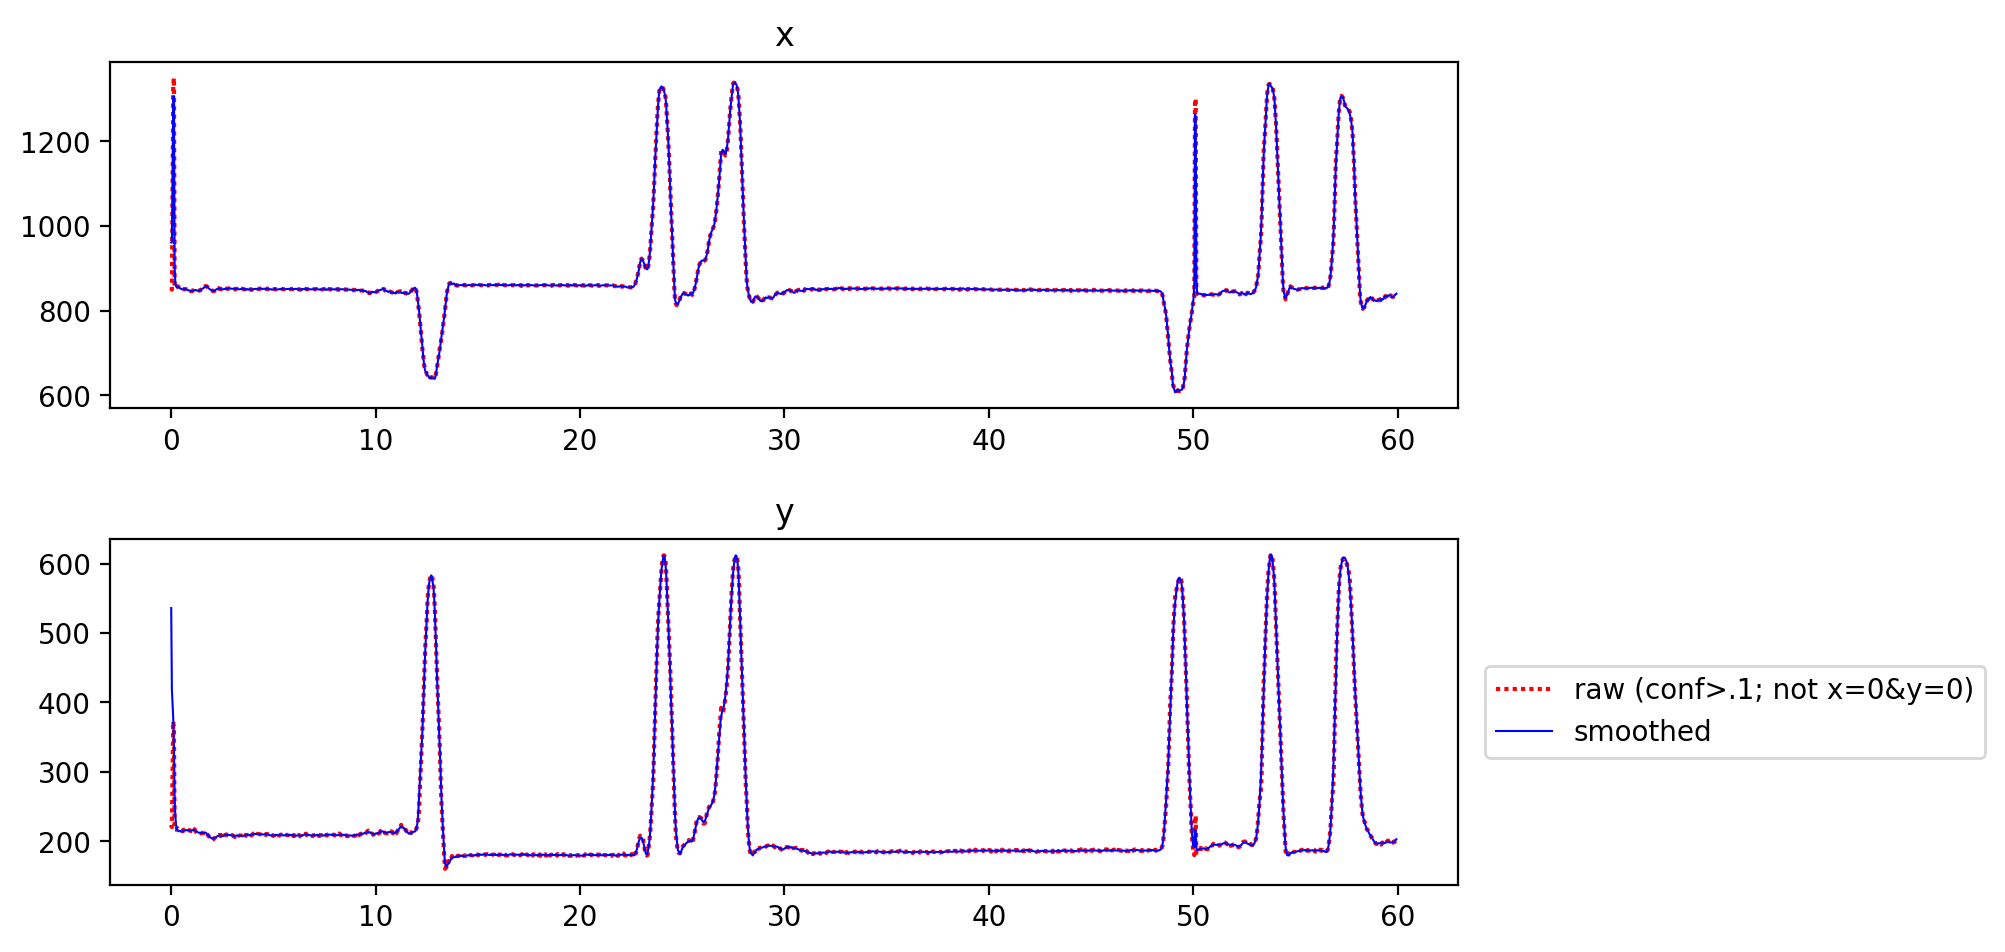

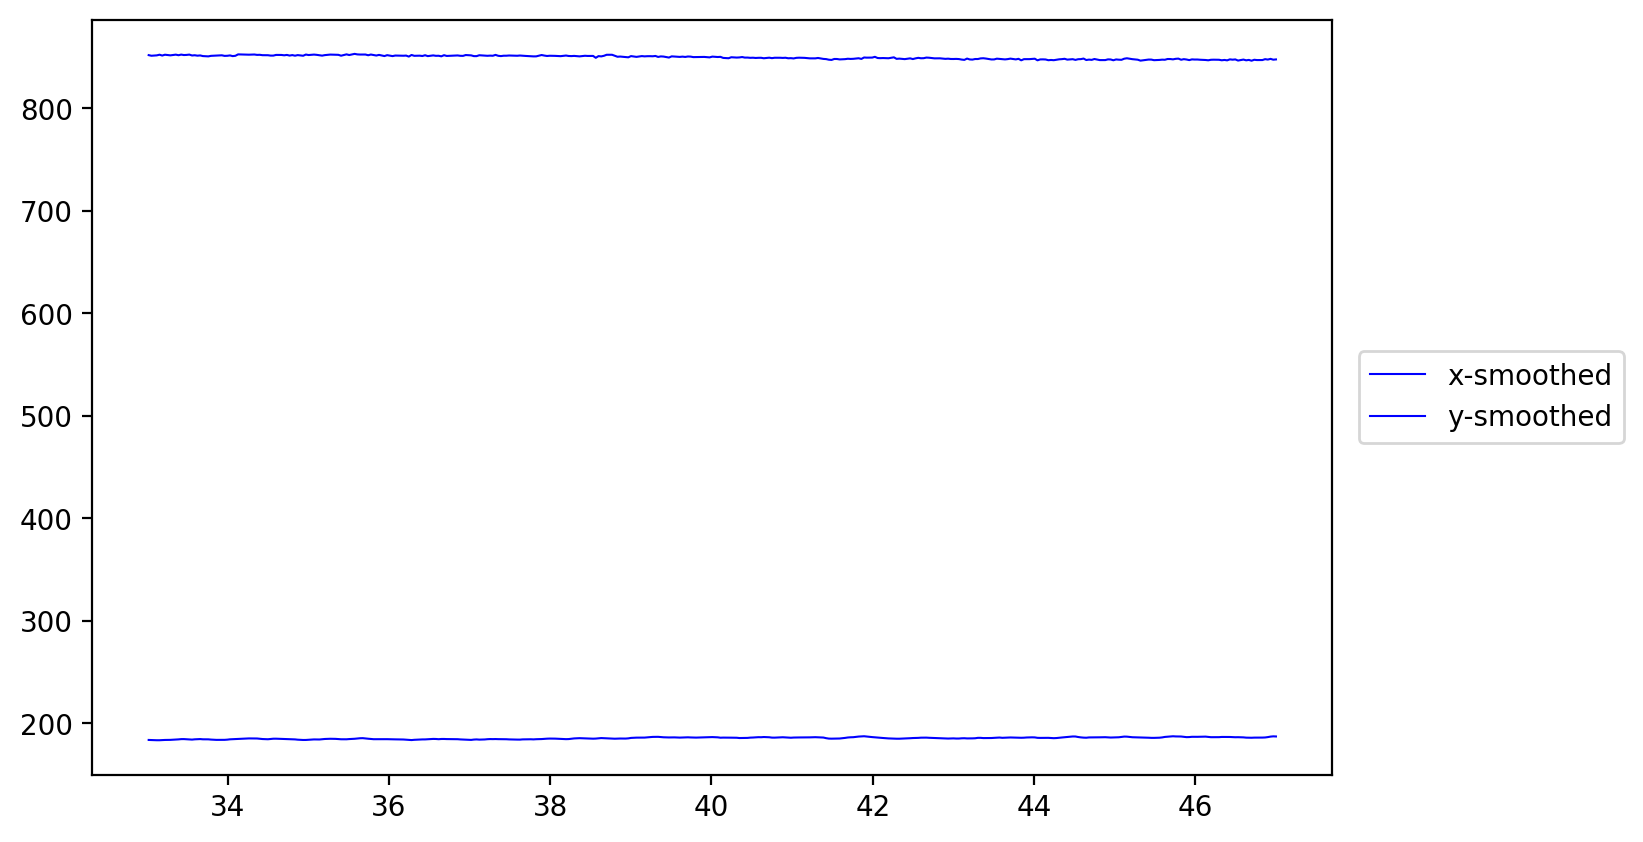

In [198]:
xs, _ = fitted_all.smooth(Zs)
plot_filter_out(times, Zs, xs)

## Put it together

I think that we should assume process noise only occurs as an acceleration (noise on the velocity).

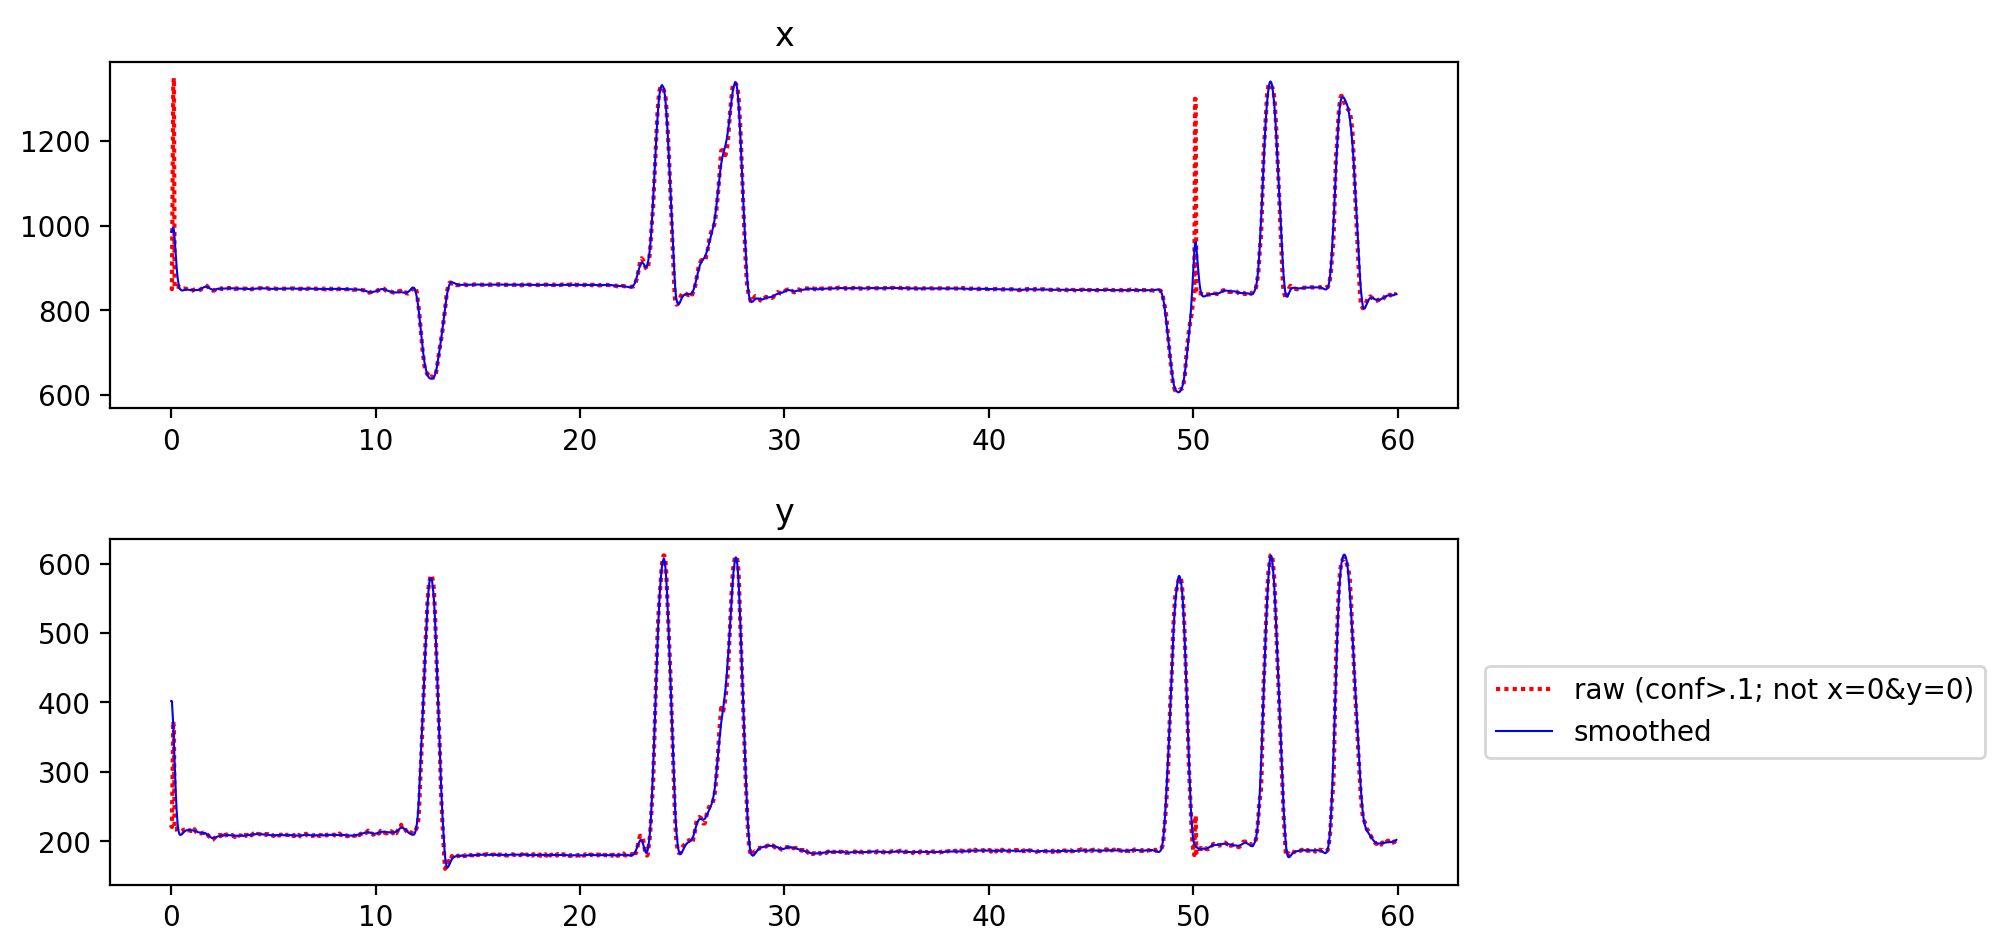

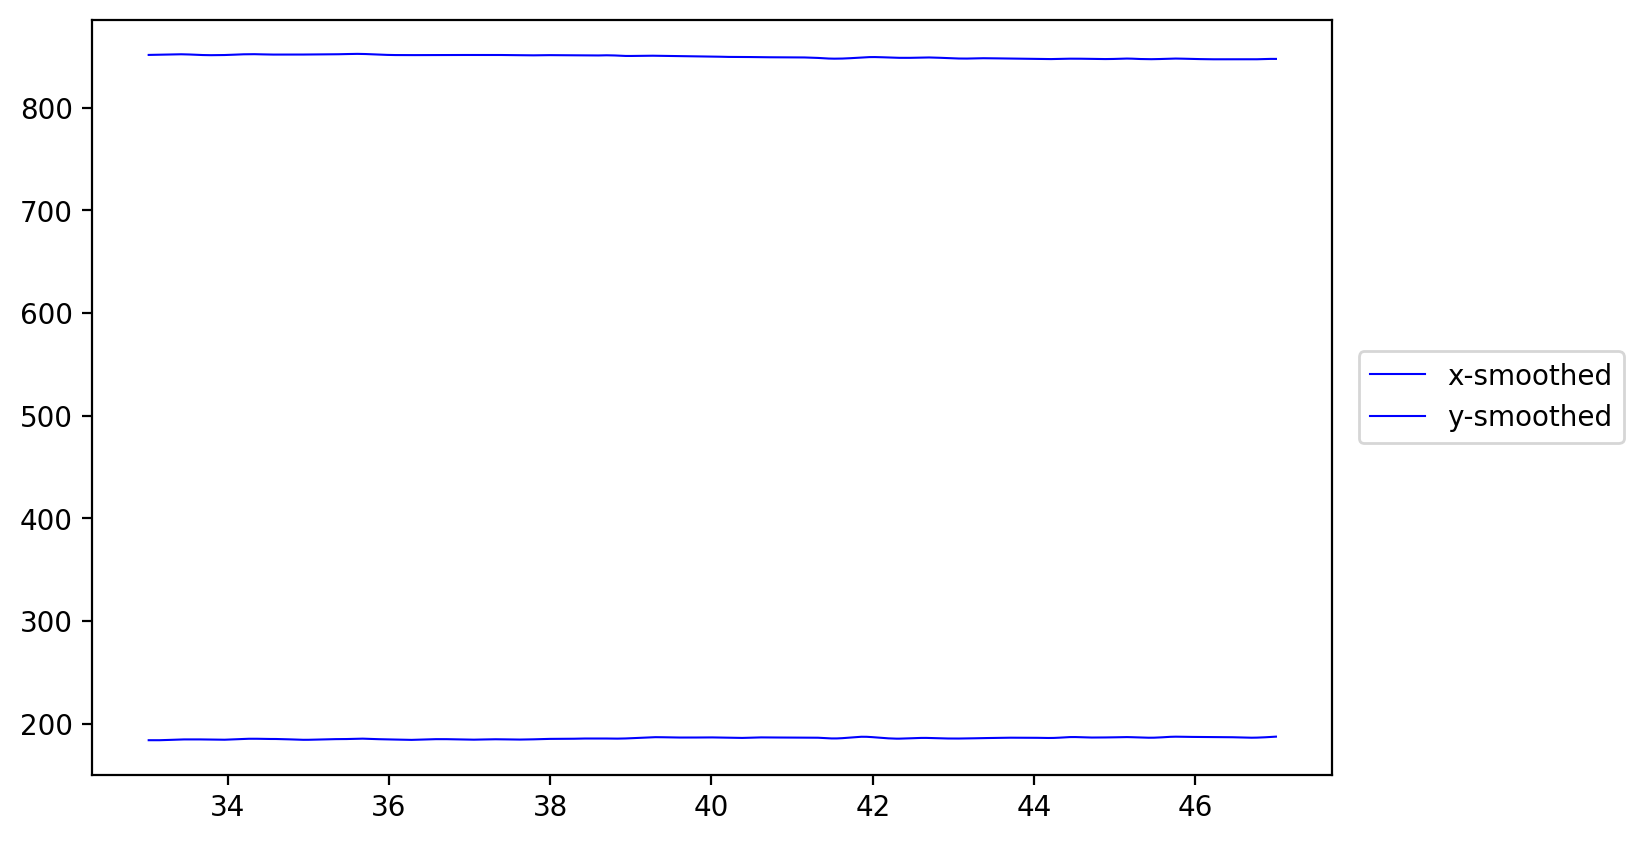

In [230]:
full_fitted_flat = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
                           initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]),
                            observation_covariance=np.eye(2)*(2**2),
                                        transition_covariance=np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]])*80)
xs, _ = full_fitted_flat.smooth(Zs)
plot_filter_out(times, Zs, xs)
